In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import mlflow


In [2]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-training/02-experiment-tracking/mlruns/1', creation_time=1747749545781, experiment_id='1', last_update_time=1747749545781, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
filename = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet'
val_filename = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet'
categorical_features = ['PULocationID', 'DOLocationID']
def read_process_dataframe(filename):
    df = pd.read_parquet(filename)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df['trip_duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['trip_duration'] = df['trip_duration'].apply(lambda time_delta: time_delta.total_seconds()/60)
    df = df[(df.trip_duration >= 1) & (df.trip_duration <= 60)]
    df[categorical_features] = df[categorical_features].astype('str')
    return df

In [4]:
!python -V

Python 3.9.12


In [5]:
df_train = read_process_dataframe(filename)
df_val = read_process_dataframe(val_filename)
categorical_features = ['PU_DU']
df_train['PU_DU'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DU'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,trip_duration,PU_DU
0,2,2025-02-01 00:12:15,2025-02-01 00:15:48,N,1.0,166,41,1.0,0.65,6.50,...,0.00,NaN,1.0,10.80,1.0,1.0,0.00,0.00,3.550000,166_41
1,2,2025-01-31 23:57:05,2025-02-01 00:24:24,N,1.0,255,161,1.0,6.57,31.70,...,0.00,NaN,1.0,37.70,2.0,1.0,2.75,0.75,27.316667,255_161
2,2,2025-02-01 00:24:26,2025-02-01 00:49:54,N,1.0,75,182,2.0,8.36,36.60,...,0.00,NaN,1.0,39.10,2.0,1.0,0.00,0.00,25.466667,75_182
3,1,2025-02-01 00:17:15,2025-02-01 00:25:56,N,1.0,97,209,1.0,2.40,12.80,...,0.00,NaN,1.0,22.55,1.0,1.0,2.75,0.75,8.683333,97_209
4,2,2025-02-01 00:17:36,2025-02-01 00:26:36,N,1.0,7,223,1.0,1.31,10.70,...,0.00,NaN,1.0,15.84,1.0,1.0,0.00,0.00,9.000000,7_223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46616,2,2025-02-28 22:35:00,2025-02-28 23:10:00,None,NaN,181,161,NaN,8.23,44.39,...,0.00,NaN,1.0,56.80,NaN,NaN,NaN,0.75,35.000000,181_161
46617,2,2025-02-28 23:40:00,2025-02-28 23:55:00,None,NaN,166,141,NaN,4.10,27.67,...,0.00,NaN,1.0,38.30,NaN,NaN,NaN,0.00,15.000000,166_141
46618,2,2025-02-28 23:34:00,2025-02-28 23:48:00,None,NaN,41,48,NaN,4.09,27.71,...,0.00,NaN,1.0,32.71,NaN,NaN,NaN,0.75,14.000000,41_48
46619,2,2025-02-28 23:52:00,2025-03-01 00:05:00,None,NaN,75,140,NaN,2.25,16.64,...,0.00,NaN,1.0,21.89,NaN,NaN,NaN,0.00,13.000000,75_140


In [6]:
dv = DictVectorizer()
numerical_features = ['trip_distance']

train_dicts = df_train[categorical_features + numerical_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical_features + numerical_features].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [7]:
y_train = df_train.trip_duration.values
y_val = df_val.trip_duration.values

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_pred, y_val, squared=False)

6.098350358470145

In [9]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [10]:
with mlflow.start_run():
    alpha_var = 0.01
    mlflow.set_tag("Dev", "Yogesh")
    mlflow.log_param("DataTrain",filename)
    mlflow.log_param("ValTrain",val_filename)
    mlflow.log_param("Alpha", alpha_var)
    lr = Lasso(alpha_var)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_pred, y_val, squared=False)
    mlflow.log_metric("RMSE", rmse)

In [11]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [18]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [ ]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=50,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
    return {'loss': rmse, 'status': STATUS_OK}

In [20]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:03:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.59715                           
[1]	validation-rmse:8.15277                           
[2]	validation-rmse:7.76662                           
[3]	validation-rmse:7.43265                           
[4]	validation-rmse:7.14449                           
[5]	validation-rmse:6.89679                           
[6]	validation-rmse:6.68491                           
[7]	validation-rmse:6.50443                           
[8]	validation-rmse:6.35174                           
[9]	validation-rmse:6.22185                           
[10]	validation-rmse:6.11007                          
[11]	validation-rmse:6.01616                          
[12]	validation-rmse:5.93718                          
[13]	validation-rmse:5.87018                          
[14]	validation-rmse:5.81404                          
[15]	validation-rmse:5.76632                          
[16]	validation-rmse:5.72629                          
[17]	validation-rmse:5.69197                          
[18]	valid

2025/05/20 16:04:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:04:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."

2025/05/20 16:04:24 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp_wwkrr6j/model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 

job exception: [Errno 2] No such file or directory: 'local_path=models/lin_reg.bin'



  0%|          | 0/50 [00:34<?, ?trial/s, best loss=?]


FileNotFoundError: [Errno 2] No such file or directory: 'local_path=models/lin_reg.bin'

In [24]:
import mlflow.xgboost
import mlflow.xgboost
import mlflow.xgboost
params = {
    'max_depth': 6,
    'learning_rate': 0.2605702277747,
    'reg_alpha': 0.1827340010199075,
    'reg_lambda': 0.04027087924020336,
    'min_child_weight': 3.9229053708437247,
    'objective': 'reg:linear',
    'seed': 42
}
mlflow.xgboost.autolog(disable=True)
with mlflow.start_run():
    mlflow.set_tag("model", "xgboost")
    mlflow.log_params(params)
    booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
    )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")                        
    mlflow.xgboost.log_model(booster,artifact_path="models_mlflow")


[0]	validation-rmse:7.79401
[1]	validation-rmse:6.95177
[2]	validation-rmse:6.43064
[3]	validation-rmse:6.11773
[4]	validation-rmse:5.92262


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:25:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[5]	validation-rmse:5.80448
[6]	validation-rmse:5.73324
[7]	validation-rmse:5.68379
[8]	validation-rmse:5.65692
[9]	validation-rmse:5.63714
[10]	validation-rmse:5.61904
[11]	validation-rmse:5.60875
[12]	validation-rmse:5.59934
[13]	validation-rmse:5.59319
[14]	validation-rmse:5.58993
[15]	validation-rmse:5.58486
[16]	validation-rmse:5.58180
[17]	validation-rmse:5.57774
[18]	validation-rmse:5.57527
[19]	validation-rmse:5.57243
[20]	validation-rmse:5.56937
[21]	validation-rmse:5.56668
[22]	validation-rmse:5.56395
[23]	validation-rmse:5.56115
[24]	validation-rmse:5.55917
[25]	validation-rmse:5.55584
[26]	validation-rmse:5.55363
[27]	validation-rmse:5.54923
[28]	validation-rmse:5.54730
[29]	validation-rmse:5.54535
[30]	validation-rmse:5.54370
[31]	validation-rmse:5.54168
[32]	validation-rmse:5.54019
[33]	validation-rmse:5.53807
[34]	validation-rmse:5.53615
[35]	validation-rmse:5.53427
[36]	validation-rmse:5.53285
[37]	validation-rmse:5.53128
[38]	validation-rmse:5.52989
[39]	validation-rms

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:26:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/20 16:26:15 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmps3sakmgp/model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 
2025/05/20 16:26:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [25]:
import mlflow
logged_model = 'runs:/c1ef679c213a447399aa8f44ac2fc489/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [26]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: c1ef679c213a447399aa8f44ac2fc489

In [28]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

In [30]:
y_pred = xgboost_model.predict(valid)
y_pred[:10]

array([ 5.2879367, 24.86037  , 24.660261 , 14.512863 ,  9.632125 ,
       14.315019 ,  6.21798  , 22.985079 , 22.13595  , 10.148207 ],
      dtype=float32)

In [31]:
from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [38]:
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops-training/02-experiment-tracking/mlruns/1', creation_time=1747749545781, experiment_id='1', last_update_time=1747749545781, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1747749530127, experiment_id='0', last_update_time=1747749530127, lifecycle_stage='active', name='Default', tags={}>]

In [39]:
client.create_experiment(name="test-experiment-using-api")

'2'

In [46]:
from mlflow.entities import ViewType
runs = client.search_runs(experiment_ids='1', 
                   filter_string="", 
                   run_view_type=ViewType.ACTIVE_ONLY,
                   max_results=3,
                   order_by=['metrics.rmse']
                   )

In [48]:
runs

[<Run: data=<RunData: metrics={'rmse': 5.289314044895425}, params={'learning_rate': '0.2605702277747',
  'max_depth': '6',
  'min_child_weight': '3.9229053708437247',
  'objective': 'reg:linear',
  'reg_alpha': '0.1827340010199075',
  'reg_lambda': '0.04027087924020336',
  'seed': '42'}, tags={'mlflow.log-model.history': '[{"run_id": "c1ef679c213a447399aa8f44ac2fc489", '
                              '"artifact_path": "models_mlflow", '
                              '"utc_time_created": "2025-05-20 '
                              '16:26:12.428596", "model_uuid": '
                              '"1101ddd3419e4cf49a52669af8eb15bb", "flavors": '
                              '{"python_function": {"loader_module": '
                              '"mlflow.xgboost", "python_version": "3.9.12", '
                              '"data": "model.xgb", "env": {"conda": '
                              '"conda.yaml", "virtualenv": "python_env.yaml"}}, '
                              '"xgboost": {"xg

In [52]:
for run in runs:
    print(f"run_id: {run.info.run_id}")

run_id: c1ef679c213a447399aa8f44ac2fc489
run_id: dd5aea663b7945098f6648ca32599d46
run_id: b05c7eab70794a39911323893a5fa1cd


In [54]:
run_id = "c1ef679c213a447399aa8f44ac2fc489"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri=model_uri, name="nyc_taxi_trip")


Successfully registered model 'nyc_taxi_trip'.
Created version '1' of model 'nyc_taxi_trip'.


<ModelVersion: aliases=[], creation_timestamp=1747761620365, current_stage='None', description=None, last_updated_timestamp=1747761620365, name='nyc_taxi_trip', run_id='c1ef679c213a447399aa8f44ac2fc489', run_link=None, source='/workspaces/mlops-training/02-experiment-tracking/mlruns/1/c1ef679c213a447399aa8f44ac2fc489/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


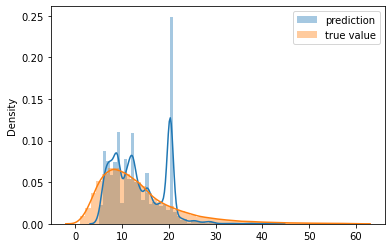

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='true value')
plt.legend()